<a href="https://colab.research.google.com/github/gtbook/robotics/blob/main/S41_logistics_state.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install -q -U gtbook

Note: you may need to restart the kernel to use updated packages.


In [2]:
import math
import numpy as np
from numpy.random import default_rng
rng = default_rng()

import plotly.express as px
import plotly.graph_objects as go
try:
    import google.colab
except:
    import plotly.io as pio
    pio.renderers.default = "png"

import gtsam
from gtbook import logistics

# Continuous State

> Our warehouse robots live in the 2D plane, and have no notion of orientation.

**This Section is still in draft mode and was released for adventurous spirits (and TAs) only.**

In [3]:
from gtbook.display import randomImages
from IPython.display import display
display(randomImages(4, 1, "steampunk", 1))

Imagine a vast warehouse, with rows of storage, a flat concrete floor, and many people operating alongside robots to fulfill orders and/or store goods in the storage structures. The type of robot we are imagining here is an omni-directional flatbed robot on which heavy goods can be transported, either autonomously or directed by a human supervisor.

In this chapter we will make a simplifying assumption, and assume that the orientation of the robot is either known or does not matter. The easiest is to imagine that the flatbed robot is always oriented in a canonical orientation with respect to the dominant warehouse (presumably, "Manhattan-like") directions. Under this assumption, we can concisely capture the robot state, at least as it pertains to navigation, as a point $x$ in a 2D space:

$$x\in\mathbb{R}^2$$

## Representing Knowledge with Probability Densities

Having a continuous representation immediately begs the question how we will handle probabilistic knowledge about the state. In the discrete case, this was fairly straightforward, as the state space in that case is finite and we accord a probability value with every possible value of the state. This is no longer the case for continuous variables: the state space is infinite. Not that is even the case when we *bound* the continuous coordinates to a certain interval: we still have an infinite number of possible real numbers inside a finite interval.

The answer is a ***probability density**: with each value $x$ of the state we associate a density $p(x)$.  We can find the *probability* of the state $x$ being contained in any finite subset $S$ by integrating over it:

$$P(x\in S) = \int_{x\in S} p(x)$$

In addition, the equivalent axiom of probability says that, if we integrate over the *entire* state space, the probability of that event has to be one:

$$\int_x p(x) = 1$$


## Continuous Density Representations

There are three ways to represent knowledge in continuous state spaces that we will discuss in this chapter: 
1. Gaussian densities;
2. finite elements;
3. using samples.

Gaussian densities are the easiest, as we have already encountered them in a previous chapter, at least in 1D. The finite elements method comes down to simply choosing a discretization scheme, and working exactly as before, associating a probability distribution with the set of now *finite* elements. The other approach is to instead use continuous samples as a proxy for knowledge. We will dive into both these representations below.

Before we do, let us make the warehouse example a bit more concrete, by specifying some dimensions. Assuming a basic rectangular shape, 100 by 50 meters seems like a good size warehouse, similar to a typical DIY store. 


## Gaussian Densities

A Gaussian density in $\mathbb{R}^n$ can be represented using just two quantities: a **mean** $\mu\in\mathbb{R}^n$ and a **covariance matrix** $\Sigma\in\mathbb{R}^{n\times n}$. Before we have seen Gaussian densities over a 1-dimensional state space:

$$\mathcal{N}(x;\mu,\sigma^2) \doteq \frac{1}{k} \exp\{ - \frac{1}{2} \frac{\|x-\mu\|^2}{\sigma^2} \}$$

where $k=\sqrt{2\pi}\sigma$ is a normalization constant. Note that the negative log of a 1D Gaussian can be interpreted as an error or "energy", and is simply a quadratic. This fact is worth emphasizing: *a Gaussian density is the probability density associated with a quadratic error function with zero error at the mean $\mu$ and curvature $\sigma^2$.* We suggestively write this quadratic below as

$$\mathcal{E}(x;\mu,\sigma^2) \doteq \frac{1}{2} (x-\mu)\sigma^{-2}(x-\mu)$$

In the multivariate case, when $x\in\mathbb{R}^n$, the quantity $x-\mu$ is a *vector*, and hence to generalize the *scalar* error function $\mathcal{E}$ we write

$$\mathcal{E}(x;\mu,\Sigma) \doteq \frac{1}{2} (x-\mu)^T\Sigma^{-1}(x-\mu)$$

where now $\Sigma$ is an $n\times$ covariance matrix, a symmetric matrix that characterizes the curvature of a quadratic in multiple dimensions. We plug the above into the exponential to get the equation defining a **multivariate Gaussian density**:

$$\mathcal{N}(x;\mu,\Sigma) \doteq \frac{1}{k} \exp\{ - \frac{1}{2} (x-\mu)^T\Sigma^{-1}(x-\mu) \}$$

The (non-obvious) normalization constant k can be written very elegantly by taking the determinant of $2\pi\Sigma$:

$$k=\sqrt{(2\pi)^{n}|\Sigma|}=\sqrt{|2\pi\Sigma|}.$$

Another name for multivariate Gaussian probability density is the multivariate normal distribution. We prefer to use *density* to denote its continuous nature, and Gaussian instead of "normal", but It is good to be aware of both nomenclatures.

 In python, none of the packages we rely on in gtbook define a Gaussian, but it is easy enough to do in code:

In [4]:
def gaussian(x:np.array, mean=np.zeros((2,)), cov=np.eye(2)):
    """Evaluate multivariate Gaussian at x of shape(m,n), yields (m,) vector."""
    assert x.shape[-1]==2, f"error: x has shape {x.shape}"
    k = math.sqrt(np.linalg.det(2*math.pi*cov))
    e = x - mean
    E = np.sum(e * (e @ np.linalg.inv(cov)), axis=-1)
    return np.exp(-E)/k

The simple code above has limitations: it *only* works for dimensionality $n\geq2$. I could be made to work for 1D with some more work. In this chapter we will working in 2D, so below we show the effect of mean and covariance as density contour plots:

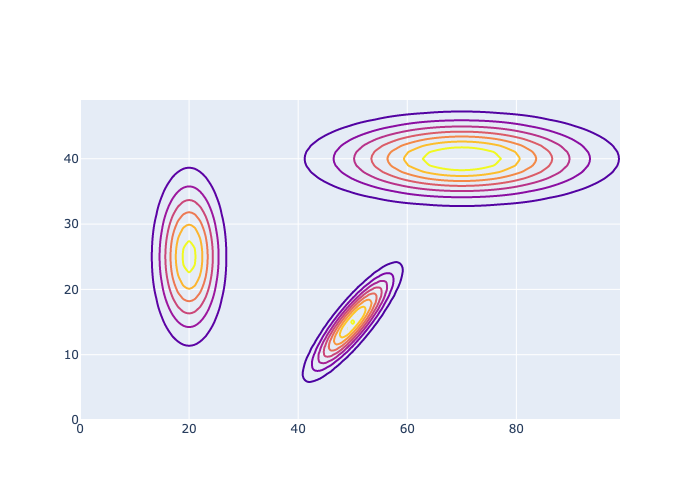

In [5]:
# show off some 2D Gaussians
means = [gtsam.Point2(x,y) for x,y in [(20,25),(70,40),(50,15)]]
covariances = [np.diag([sx**2,sy**2]) for sx,sy in [(5,10),(20,5)]]
covariances.append(np.array([[40,35],[35,40]]))

data = [go.Contour(z=gaussian(logistics.map_coords, mean, cov), contours_coloring='lines', 
        line_width=2, showscale=False) for mean,cov in zip(means,covariances)]
fig = go.Figure(data=data); fig.show()

The first two Gaussians above are *axis-parallel*, and the covariance matrices simply contain the squared standard deviations of the $x$ and $y$ dimensions on their diagonals. The third Gaussian shows off the case where $x$ and $y$ are positively correlated, around a mean of $(50,15)$.

The advantage of the Gaussian as a probability density is that it is easy to specify and easy to compute with. The disadvantage is that it is a very restricted class of densities: in particular, it is a *unimodal* density, meaning that it only has a single maximum. Hence, we will never be able to represent two equally probable locations in space, for example. One way to get around that is to use a *mixture* of Gaussian densities. This is a well known technique and has its merits, but is outside the scope of this book.

## The Finite Element Method

The first method is so simple, and uses everything we already know from before. It feels a bit like a cop-out, in fact: we abandon the notion of continuous variables and again use discrete variables to represent probability distributions. And, by necessity, this representation is going to be an *approximation* of the underlying continuous probability densities.

The simplest discretization scheme is to just regularly divide up the state space into a grid of cells. In addition, we *will* have to bound the space, because otherwise we get an infinite number of cells, i.e., we would be back to square (cell) one.

The next order of business is to choose a *resolution* for our discretization scheme. If we pick 1x1 meter cells, we are looking at $100\times50=5000$ cells. But $1m^2$ seems a bit coarse for navigating with a robot. Could we get away with $10cm$ resolution? Here we see a second disadvantage of finite elements: space complexity is exponential in the number of dimensions. In our case, increasing the resolution by 10, from 1 meter to 10cm, increases the number of cells needed by $10^2=100$, from 5000 to $1000\times500=500k$.

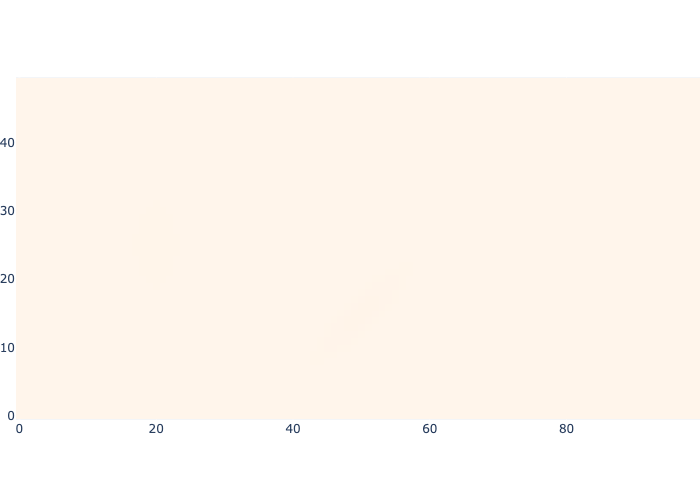

In [6]:
probabilities = np.zeros((50,100))
for mean,cov in zip(means,covariances):
    probabilities += gaussian(logistics.map_coords, mean, cov)
logistics.show_map(probabilities)

## A Sampling-based representation.

Finally, we can represent densities using *samples*.
In sampling-based methods one represents the density $p(x)$ by a set of N random samples or particles $S=\{s^{(i)};i\in1..N\}$ drawn from $p(x)$. We are able to do this because of the essential duality between the samples and the density from which they are generated: from the samples we can always approximately reconstruct the density, e.g. using a histogram.

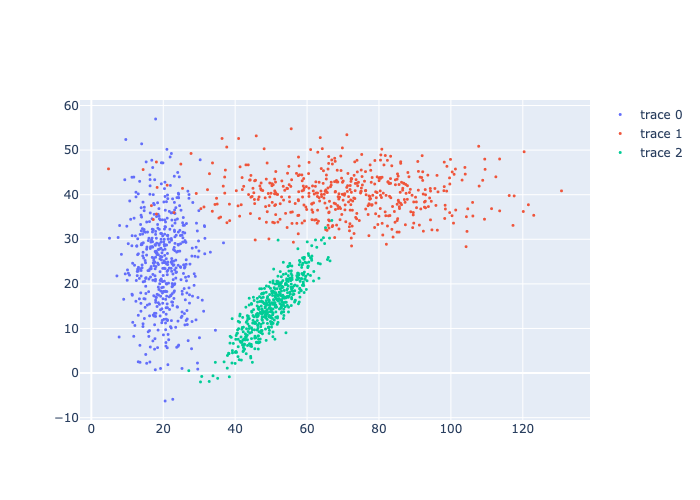

In [7]:
N=500
samples = [rng.multivariate_normal(mean, cov, size=N)
           for mean,cov in zip(means,covariances)]
data = [go.Scatter(x=sample[:,0],y=sample[:,1], mode="markers", 
        marker=dict(size=3)) for sample in samples]
fig = go.Figure(data=data); fig.show()


## GTSAM 101

> The GTSAM concepts used in this section, explained.

We really used only one thing from GTSAM above, which is `gtsam.Point2`. For maximal compatibility with numpy, in python this is just a function that creates a 2D, float numpy array. Inside GTSAM, it is represented as an Eigen vector, where Eigen is the C++ equivalent of numpy.

## GTbook 101

> About the support code we used above

Because in this chapter we will use the same code over and over again, we defined some of the key functions in the `gtbook` library accompanying this book. In particular, above we used the following variable:
- `logistics.map_coords`: a numpy array of shape (50, 100, 2) with x and y coordinates for every cell in the map, at 1m resolution.
- `logistics.show_map`: takes a probability image and plots it using plotly's `imshow` function

As always, you can get help on functions by calling `help`:

In [8]:
help(logistics.show_map)

Help on function show_map in module gtbook.logistics:

show_map(image=None, markers=None, file: str = None, marker={})
    Show image on warehouse map, possibly with markers

